# Introduction
This notebook is testing how  μMerge handles ChIP-seq replicates in comparison to other merging techniques such as bedtools merge and bedtools intersect.


# ENCODE ChIP Processing Pipeline

## REST ChIP data

The encode data was processed using the hg19 genome.

JUN REST ChIP-seq data after 25 minutes treatment with Dex \[3 replicates \]:
https://www.encodeproject.org/experiments/ENCSR604CKQ/


## Motif scanning with FIMO

- Transcription Motifs were scanned for based summit locations for each peak call

```sh
fimo -max-stored-scores 1000000 --thresh 1e-4 -oc ${outdir}/${bed} -motif $motiffile ${hocomoco}/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ${chip_fa}/${bed}_mac\
s.fa
```

## Merging Regions

- bedtools merge
- bedtools intersect
- mumerge

# Load libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/rusi2317/projects/mumerge_test/bin/mumerge_explore'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
pkg_dir='/Users/rusi2317/.local/lib/python3.6/site-packages/'
sys.path.append(os.path.abspath(pkg_dir))

In [2]:
import time
import seaborn as sns
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from mumerge_explore.load_data import *
from mumerge_explore.plot_figures import *
from mumerge_explore.process_regions import *

In [4]:
! wc -l /Users/rusi2317/projects/mumerge_test/encode_jun/data/*summits

   31975 /Users/rusi2317/projects/mumerge_test/encode_jun/data/ENCFF094MAD.bed
   31975 /Users/rusi2317/projects/mumerge_test/encode_jun/data/ENCFF094MAD.bed_summits.bed
   32281 /Users/rusi2317/projects/mumerge_test/encode_jun/data/ENCFF460JYG.bed
   32281 /Users/rusi2317/projects/mumerge_test/encode_jun/data/ENCFF460JYG.bed_summits.bed
   84409 /Users/rusi2317/projects/mumerge_test/encode_jun/data/ENCFF994MCI.bed
   84409 /Users/rusi2317/projects/mumerge_test/encode_jun/data/ENCFF994MCI.bed_summits.bed
  297330 total


## Filtering regions for merging

In [13]:
jun_samples = ['ENCFF094MAD','ENCFF460JYG','ENCFF994MCI']

#motif = '/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/fimo_scans/'
motif ='/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/fimo_scans/'
peaks = '/Users/rusi2317/projects/mumerge_test/encode_jun/data/'
outdir = '/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/significant_regions/'

for sample_name in jun_samples:
    
    fimo_hits = load_fimo(motif+sample_name+'.bed/fimo.tsv')

    fimo_filtered = filter_fimo(fimo_hits, alpha=5e-01)

    fimo_filtered_unique = unique_sig_fimo(fimo_filtered)

    fimo_sig_summit_peaks = sig_summit_peaks(peaks+sample_name+'.bed_summits.bed',
                                              fimo_filtered_unique)

    fimo_sig_narrow_peaks = final_narrow_peaks(peaks+sample_name+'.bed',
                                                fimo_sig_summit_peaks, outdir,sample_name+'_sigFimo.bed' )
    print(' ')

---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 30496
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.5 ----------
------------------------- UNIQUE FIMO HITS --------------------------
-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------
-> Macs peaks called = 31975
---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------
-> Peaks with significant hits = 15498
------------------- DONE RUNNING ENCFF094MAD_sigFimo.bed -------------------
---------------------------------------------------------------------
 
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 30289
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.5 ----------
------------------------- UNIQUE FIMO HITS --------------------------
-------------- SIGNIFICAN

## Load bed files

In [5]:
merged_files = '/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/'

merged_bed = []

for file in os.listdir(merged_files):
    if file.endswith(".bed"):
        merged_bed.append(merged_files + file)
    elif file.endswith("intersect_recursive.bed"):
        merged_bed.append(merged_files + file) 
    else:
        pass
    


In [6]:
bed_files = '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/significant_regions/'

samples =  []

for bed in os.listdir(bed_files):
    if bed.endswith('.bed'):
        samples.append(bed_files + bed)
    else:    
        pass


In [24]:
bed_files = '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/raw_data/'

samples =  []

for bed in os.listdir(bed_files):
    if bed.endswith('ENCFF094MAD.bed'):
        samples.append(bed_files + bed)
    elif bed.endswith('ENCFF460JYG.bed'):
        samples.append(bed_files + bed)
    elif bed.endswith('ENCFF994MCI.bed'):
        samples.append(bed_files + bed)
    else:    
        pass

samples    

['/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/raw_data/ENCFF094MAD.bed',
 '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/raw_data/ENCFF460JYG.bed',
 '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/raw_data/ENCFF994MCI.bed']

In [49]:
mumerged = fetch_merged_regions('/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/JUN_mumerged.bed_MUMERGE.bed')
btmerged = fetch_merged_regions('/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/JUN_merged.bed')
interset = fetch_merged_regions('/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/JUN_intersect.bed')

In [7]:
all_files = [samples + merged_bed]

fetched_regions = []
region_ids = []

for bed_regions in all_files:
    for path in bed_regions:
        print(path)
        region = fetch_merged_regions(path)
        sample_id = str.split(str.split(str(path),'/')[-1], '_')
        fetched_regions.append(region)
        region_ids.append(sample_id)

/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/significant_regions/ENCFF460JYG_sigFimo.bed
/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/significant_regions/ENCFF094MAD_sigFimo.bed
/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/significant_regions/ENCFF994MCI_sigFimo.bed
/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/JUN_merged.bed
/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/JUN_intersect.bed
/Users/rusi2317/projects/mumerge_test/encode_jun/processed_data/merged_regions/JUN_mumerged.bed_MUMERGE.bed


In [8]:
mumerged = fetched_regions[5]
interset = fetched_regions[4]
btmerged = fetched_regions[3]

(array([ 0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025]),
 <a list of 6 Text yticklabel objects>)

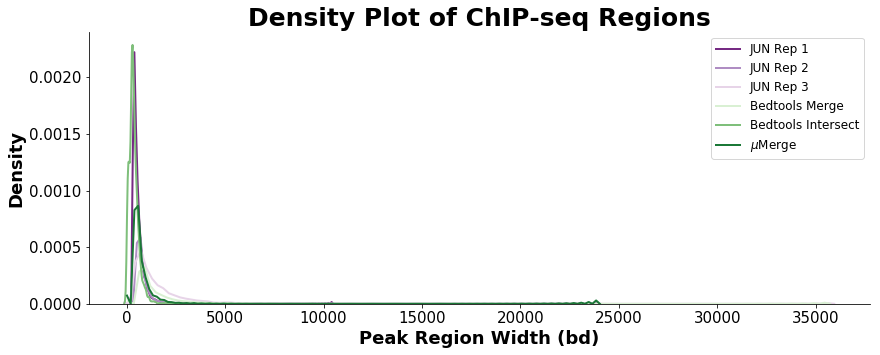

In [9]:
f = plt.figure(figsize=(14,5))

line_col = ['#762a83','#af8dc3','#e7d4e8',
           '#d9f0d3','#7fbf7b','#1b7837']

region_ids_new = ['JUN Rep 1','JUN Rep 2', 
                  'JUN Rep 3','Bedtools Merge',
                  'Bedtools Intersect',r'$\mu$Merge']

for regions, ids, cols in zip(fetched_regions, region_ids_new, line_col):
    
    ax00 = sns.distplot(regions, hist=False, kde=True,
                 bins=60, color = cols,
                 kde_kws={'shade': False,'linewidth': 2},
                 label=str(ids))
    ax00.spines['right'].set_visible(False)
    ax00.spines['top'].set_visible(False)
    
plt.legend(prop={'size': 12}, title = '')
plt.title('Density Plot of ChIP-seq Regions',fontsize=25,fontweight='bold')
plt.xlabel('Peak Region Width (bd)',fontsize=18,fontweight='bold')
plt.ylabel('Density',fontsize=18,fontweight='bold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

#f.savefig("./figures/pdf/JUN_width_distributions.pdf", bbox_inches='tight')
#f.savefig("./figures/png/JUN_width_distributions.png", bbox_inches='tight')

/opt/jupyterhub/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


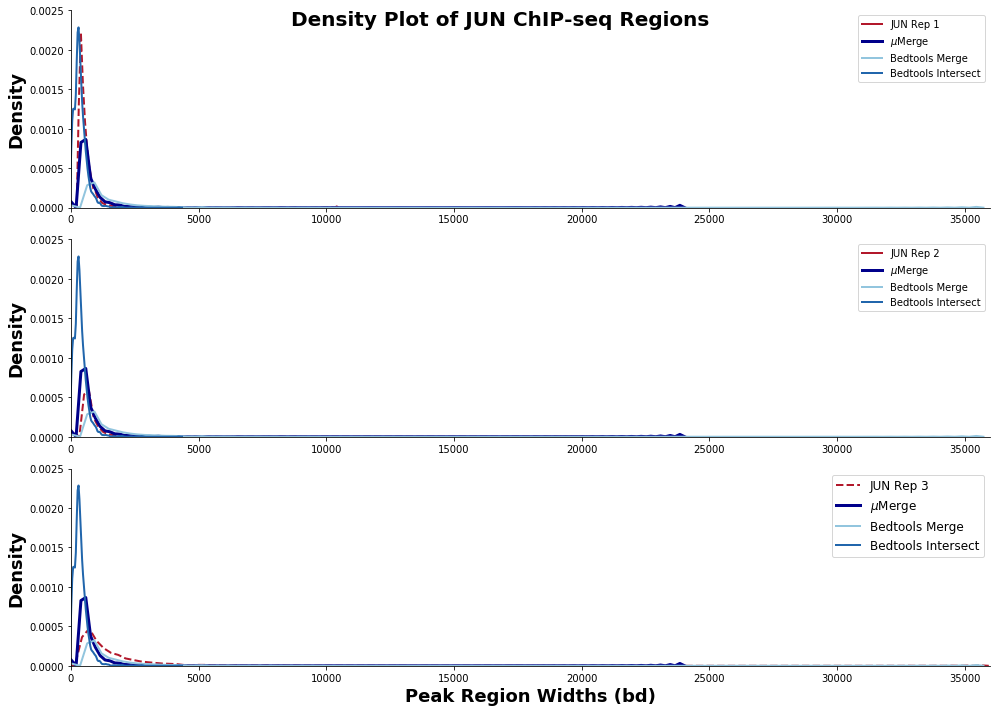

In [10]:
fig, axs = plt.subplots(nrows=3, figsize=(14,10))


for i in range(len(region_ids[0:3])):

        
        ax = sns.distplot(fetched_regions[i], hist=False, kde=True,rug = False, 
                     bins=60, color = '#b2182b', 
                     kde_kws={'shade': False,'linewidth': 2},
                     rug_kws={'color': '#b2182b'},
                     label=str(region_ids_new[i]),
                    ax=axs[i])
        
        ax = sns.distplot(fetched_regions[5], hist=False, kde=True,rug = False, 
                     bins=60, color = 'darkblue', 
                     kde_kws={'shade': False,'linewidth': 3},
                    rug_kws={'color': 'darkblue'},
                    label=r'$\mu$Merge',
                     ax=axs[i])

        ax = sns.distplot(fetched_regions[3], hist=False, kde=True,rug = False, 
                     bins=60, color = '#92c5de', 
                     kde_kws={'shade': False,'linewidth': 2},
                    rug_kws={'color': '#92c5de'},
                    label='Bedtools Merge',
                     ax=axs[i])

        ax = sns.distplot(fetched_regions[4], hist=False, kde=True,rug = False, 
                     bins=60, color = '#2166ac', 
                     kde_kws={'shade': False,'linewidth': 2},
                    rug_kws={'color': '#2166ac'},
                    label='Bedtools Intersect',
                     ax=axs[i])

        ax.lines[0].set_linestyle("--")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(prop={'size': 12}, title = '')
        plt.xlabel('Peak Region Widths (bd)', fontsize=18, fontweight='bold')
        ax.set_ylabel('Density', fontsize=18, fontweight='bold')
        ax.set(xlim=(0, 36000))
        ax.set(ylim=(0, 0.0025))

fig.suptitle('Density Plot of JUN ChIP-seq Regions', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.show()

#fig.savefig("./figures/pdf/JUN_width_distributions_multi.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_width_distributions_multi.png", bbox_inches='tight')

/opt/jupyterhub/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


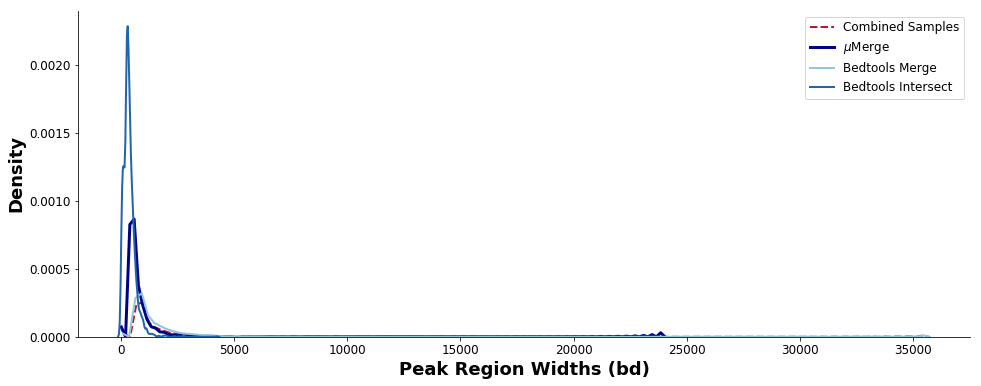

In [11]:
fig, ax_comb = plt.subplots(figsize=(16,6))
combined_samples = [j for i in fetched_regions[0:3] for j in i]


ax_comb = sns.distplot(combined_samples, hist=False, kde=True,rug = False, 
                  bins=60, color = '#b2182b', 
                  kde_kws={'shade': False,'linewidth': 2},
                  rug_kws={'color': '#b2182b'},
                  label= 'Combined Samples')

ax_comb = sns.distplot(fetched_regions[5], hist=False, kde=True,rug = False, 
                       bins=60, color = 'darkblue', 
                       kde_kws={'shade': False,'linewidth': 3},
                       rug_kws={'color': 'darkblue'},
                       label=r'$\mu$Merge')

ax_comb = sns.distplot(fetched_regions[3], hist=False, kde=True,rug = False, 
                       bins=60, color = '#92c5de', 
                       kde_kws={'shade': False,'linewidth': 2},
                       rug_kws={'color': '#92c5de'},
                       label='Bedtools Merge')

ax_comb = sns.distplot(fetched_regions[4], hist=False, kde=True,rug = False, 
                       bins=60, color = '#2166ac', 
                       kde_kws={'shade': False,'linewidth': 2},
                       rug_kws={'color': '#2166ac'},
                       label='Bedtools Intersect')

ax_comb.lines[0].set_linestyle("--")
ax_comb.spines['right'].set_visible(False)
ax_comb.spines['top'].set_visible(False)
ax_comb.set_ylabel('Density',fontsize=18,fontweight='bold')
#ax_comb.set(xlim=(0, 3000))
#ax_comb.set(ylim=(0, 0.005))

plt.legend(prop={'size': 12}, title = '')
plt.xlabel('Peak Region Widths (bd)',fontsize=18,fontweight='bold')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
fig.show()

#fig.savefig("./figures/pdf/JUN_combined_reps_width_distributions.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_combined_reps_width_distributions.png", bbox_inches='tight')

### Kullback-Liebler Divergence 

In [12]:
#calculating the region densities
counts, bin_edges = np.histogram(fetched_regions[5], bins=60, density=True)

region_densities = []

for regions, ids in zip(fetched_regions, region_ids):
    
    cnt, bns = np.histogram(regions, bins=bin_edges, density=True)
    region_densities.append(cnt)

In [13]:
##calculating density distribution entropy
kl_results = []
kl_labels = []
for dens0, ids0 in zip(region_densities, region_ids):
    for dens1, ids1 in zip(region_densities, region_ids):
        
        constant = float(1e-30)
        kl = entropy(dens0+constant, dens1+constant, base=10)
        kl_results.append(float(kl))
        kl_labels.append([ids0, ids1])

In [14]:
##creating a 2D numpy array
n=6
kl_results_array = np.array([kl_results[i:i + n] for i in range(0, len(kl_results), n)])  
print(kl_results_array) 

[[ 0.          0.01074466  0.11143504  0.03763565  0.05911186  0.00572073]
 [ 0.00478954  0.          0.11267889  0.03850895  0.05293232  0.0055667 ]
 [ 0.34087583  0.53750508  0.          0.02960018  1.85118689  0.20462918]
 [ 0.12035064  0.2092237   0.02561288  0.          0.81011439  0.06188084]
 [ 0.00841609  0.00740329  0.14799882  0.06379533  0.          0.01820591]
 [ 0.01021227  0.01965856  0.08190765  0.02064301  0.15289319  0.        ]]


In [15]:
region_ids_clean = ['JUN Rep 1','JUN Rep 2', 
                  'JUN Rep 3',
                   'Bedtools Merge','Bedtools Intersect',
                   r'$\mu$Merge']
region_ids_clean

['JUN Rep 1',
 'JUN Rep 2',
 'JUN Rep 3',
 'Bedtools Merge',
 'Bedtools Intersect',
 '$\\mu$Merge']

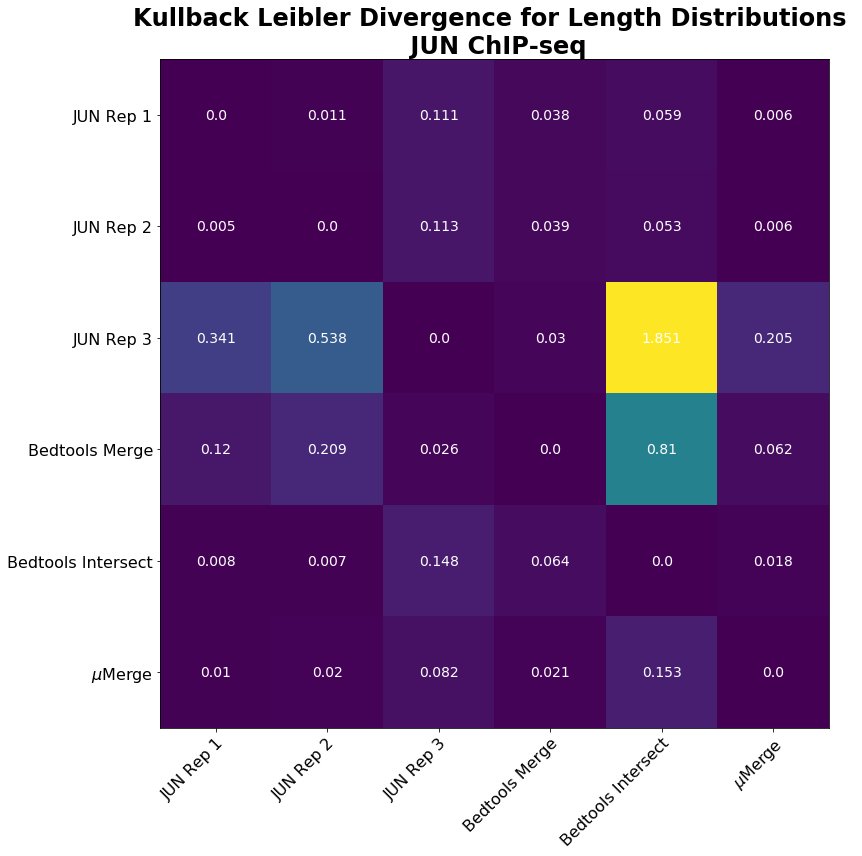

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(kl_results_array)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n JUN ChIP-seq",
            fontsize=24,fontweight='bold')

ax.set_xticks(np.arange(len(region_ids)))
ax.set_yticks(np.arange(len(region_ids)))

ax.set_xticklabels(region_ids_clean,fontsize=16)
ax.set_yticklabels(region_ids_clean,fontsize=16)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(region_ids)):
    for j in range(len(region_ids)):
        text = ax.text(j, i, round(kl_results_array[i, j],3),
                       ha="center", va="center", color="w",
                       fontsize=14)

fig.tight_layout()
plt.show()

#fig.savefig("./figures/pdf/JUN_KL.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_KL.png", bbox_inches='tight')

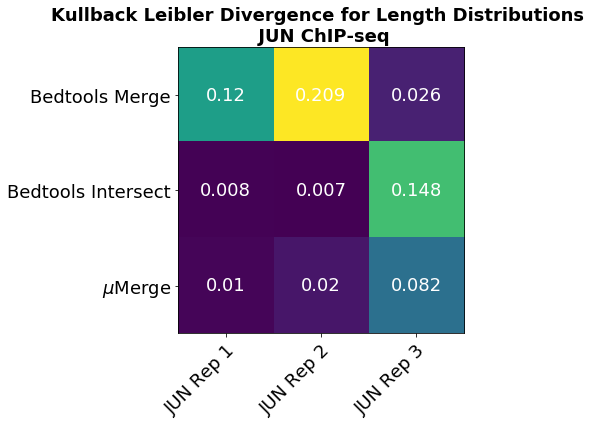

In [23]:
##filter mumerge comparisons with the samples
merge_kl = kl_results_array[3:6,0:3]

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(merge_kl)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n JUN ChIP-seq",
            fontsize=18,fontweight='bold')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))

ax.set_xticklabels(region_ids_clean[0:3],fontsize=18)
ax.set_yticklabels(region_ids_clean[3:6],fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(3):
    for j in range(3):
        text = ax.text(j, i, round(merge_kl[i, j],3),
                       ha="center", va="center", color="w",
                       fontsize=18)

fig.tight_layout()
plt.show()

#fig.savefig("./figures/pdf/JUN_KL_truncated.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_KL_truncated.png", bbox_inches='tight')

In [24]:
combined_regions = [combined_samples] + [btmerged] + [interset] + [mumerged] 
combined_ids = ['Combined Replicates','Bedtools Merge', 'Bedtools Intersect', r'$\mu$Merge']

##using the bin edges from the mumerge regions
counts, bin_edges = np.histogram(mumerged, bins=60, density=True)

combined_region_densities = []

for regions, ids in zip(combined_regions, combined_ids):
    
    cnt, bns = np.histogram(regions, bins=bin_edges, density=True)
    combined_region_densities.append(cnt)

In [25]:
## Kullback-Liebler Divergence 
kl_results_comb = []
kl_labels_comb = []
for dens0, ids0 in zip(combined_region_densities, combined_ids):
    for dens1, ids1 in zip(combined_region_densities, combined_ids):
        
        constant = float(1e-30)
        kl = entropy(dens0+constant, dens1+constant, base=10)
        kl_results_comb.append(float(kl))
        kl_labels_comb.append([ids0, ids1])

In [26]:
n=4
x_comb = np.array([kl_results_comb[i:i + n] for i in range(0, len(kl_results_comb), n)])  
print(x_comb) 

[[ 0.          0.00553783  0.50833298  0.02887645]
 [ 0.00608254  0.          0.81011439  0.06188084]
 [ 0.03606728  0.06379533  0.          0.01820591]
 [ 0.00664489  0.02064301  0.15289319  0.        ]]


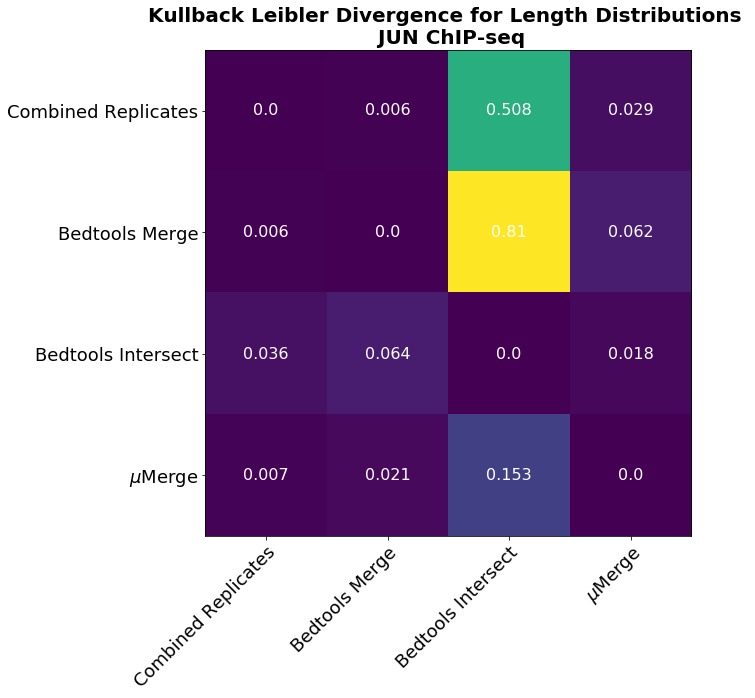

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x_comb)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n JUN ChIP-seq",
            fontsize=20,fontweight='bold')

ax.set_xticks(np.arange(len(combined_ids)))
ax.set_yticks(np.arange(len(combined_ids)))

ax.set_xticklabels(combined_ids,fontsize=18)
ax.set_yticklabels(combined_ids,fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(combined_ids)):
    for j in range(len(combined_ids)):
        text = ax.text(j, i, round(x_comb[i, j],3),
                       ha="center", va="center", color="w",
                       fontsize=16)

fig.tight_layout()
plt.show()

#fig.savefig("./figures/pdf/JUN_KL_combined_reps.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_KL_combined_reps.png", bbox_inches='tight')

## Surveying Motif - Summit distances

In [29]:
##individual samples
encode_samples = ['ENCFF094MAD.bed','ENCFF460JYG.bed','ENCFF994MCI.bed']

sample_narrow = '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/raw_data/' 
sample_fimo = '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/fimo_scans_whole_seq/'

sample_distances = []
sample_motif_sig = []

for sample_name in encode_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    macs_results = load_bed(sample_narrow + sample_name)
    macs_summit = load_bed(sample_narrow + sample_name + '_summits.bed')
    fimo_hits = load_fimo(sample_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(fimo_hits, alpha=5e-01)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig = summit_motif_dist(macs_results, macs_summit, fimo_filtered_unique)
    
    sample_distances.append(motif_peak_dist)
    sample_motif_sig.append(motif_sig)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......ENCFF094MAD.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 12464
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.5 ----------
Sequences with motif hits => 9687
.....DONE processing.....ENCFF094MAD.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......ENCFF460JYG.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 12502
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.5 ----------
Sequences with motif hits => 9713
.....DONE processing.....ENCFF460JYG.bed
---------------------------------------------------------------------
 
----------

In [31]:
##merged regions
merge_samples = ['JUN_intersect.bed',
                 'JUN_merged.bed',
                 'JUN_mumerged.bed_MUMERGE.bed']

summary_narrow = '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/merged_regions/' 
summary_fimo = '/scratch/Users/rusi2317/projects/encode_mumerge_test/jun/processed_data/fimo_scans_whole_seq/' 

merge_distances = []
merge_motif_sig = []

for sample_name in merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(summary_narrow + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(summary_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=5e-01)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig = summit_motif_dist(merged_narrow, merged_summit, fimo_filtered_unique)
    
    merge_distances.append(motif_peak_dist)
    merge_motif_sig.append(motif_sig)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......JUN_intersect.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 1931
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.5 ----------
Sequences with motif hits => 1446
.....DONE processing.....JUN_intersect.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......JUN_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 24079
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.5 ----------
Sequences with motif hits => 17105
.....DONE processing.....JUN_merged.bed
---------------------------------------------------------------------
 
--------

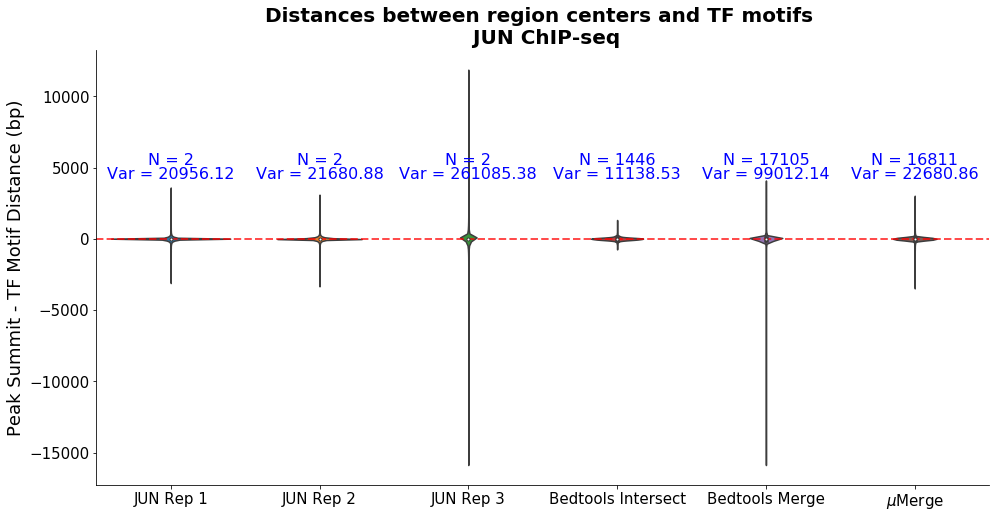

In [80]:
total_distances = sample_distances + merge_distances

variance = []

for v in total_distances:
    var = np.var(v)
    variance.append(var)
    
for s in total_distances:
    std = np

total_ids = ['JUN Rep 1','JUN Rep 2', 'JUN Rep 3',
             'Bedtools Intersect', 
            'Bedtools Merge',
            r'$\mu$Merge']

fig, ax05 = plt.subplots(figsize=(16, 8))

ax05 = sns.violinplot(data=total_distances, cut=0, inner='box')
ax05.axhline(0, ls='--', color='red', linewidth=2, alpha=.7)
ax05.set_xticklabels(total_ids)

ax05.set_title('Distances between region centers and TF motifs \n JUN ChIP-seq',
             fontsize=20, fontweight='bold')
ax05.set_xlabel(' ')
ax05.set_ylabel('Peak Summit - TF Motif Distance (bp)',fontsize=18)
ax05.spines['right'].set_visible(False)
ax05.spines['top'].set_visible(False)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0,1,2,3,4,5], variance, total_distances):
    text = ax05.text(i, 5500, 'N = ' + str(len(k)),
                        ha="center", va="center", color="blue",
                        fontsize=16)
    text = ax05.text(i, 4500, 'Var = ' + str(round(j, 2)),
                       ha="center", va="center", color="blue",
                       fontsize=16)
    
#fig.savefig("./figures/pdf/JUN_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_RegionCenter_Motif_distances.png", bbox_inches='tight')

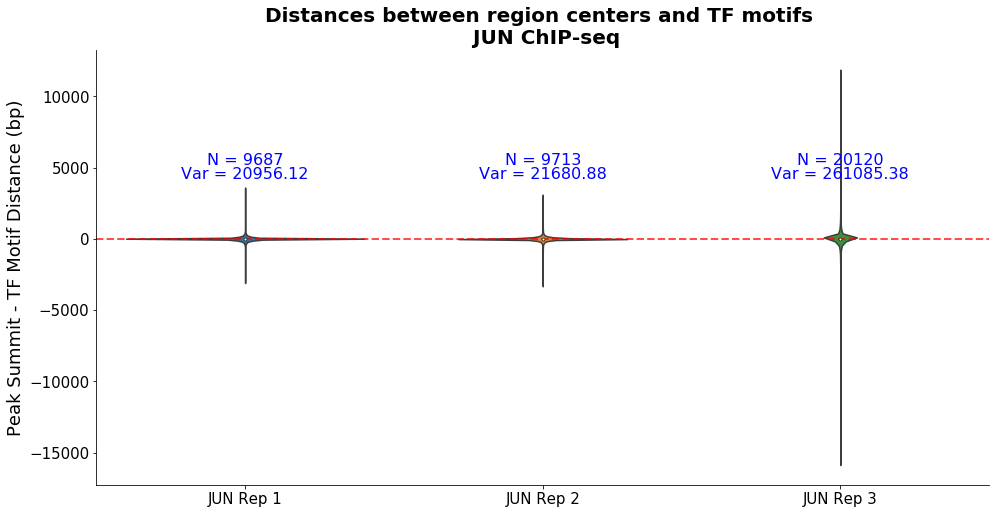

In [78]:
#total_distances = sample_distances + merge_distances

variance_samples = []

for v in sample_distances:
    var = np.var(v)
    variance_samples.append(var)

sample_ids = ['JUN Rep 1','JUN Rep 2', 'JUN Rep 3']

fig, ax05 = plt.subplots(figsize=(16, 8))

ax05 = sns.violinplot(data=sample_distances, cut=0, inner='box')
ax05.axhline(0, ls='--', color='red', linewidth=2, alpha=.7)
ax05.set_xticklabels(sample_ids)

ax05.set_title('Distances between region centers and TF motifs \n JUN ChIP-seq',
             fontsize=20, fontweight='bold')
ax05.set_xlabel(' ')
ax05.set_ylabel('Peak Summit - TF Motif Distance (bp)',fontsize=18)
ax05.spines['right'].set_visible(False)
ax05.spines['top'].set_visible(False)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0,1,2], variance_samples, sample_distances):
    text = ax05.text(i, 5500, 'N = ' + str(len(sample_distances[i][0])),
                        ha="center", va="center", color="blue",
                        fontsize=16)
    text = ax05.text(i, 4500, 'Var = ' + str(round(j, 2)),
                       ha="center", va="center", color="blue",
                       fontsize=16)
    
#fig.savefig("./figures/pdf/JUN_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_RegionCenter_Motif_distances.png", bbox_inches='tight')



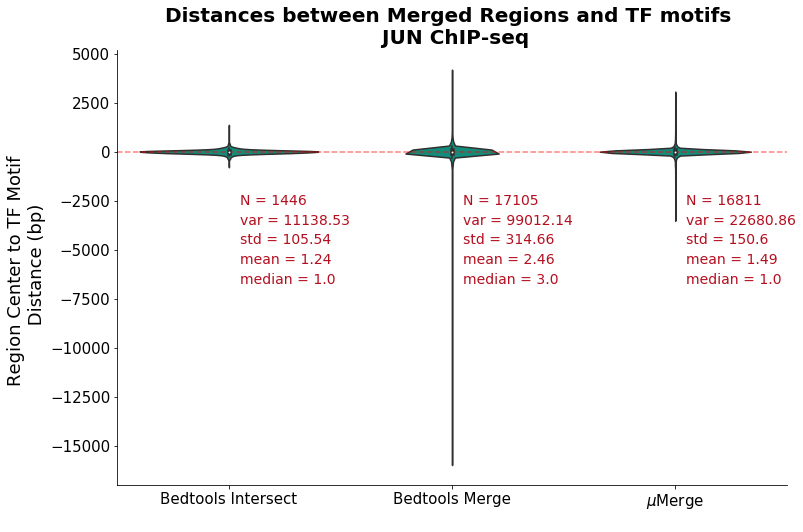

In [39]:
fig, ax06 = plt.subplots(figsize=(12, 8))

ax06 = sns.violinplot(data=total_distances[3:], inner='box',color="#00A08A") 
ax06.axhline(0, ls='--', color='red', linewidth=1.5, alpha=.5)
ax06.set_xticklabels(total_ids[3:])

ax06.set_title('Distances between Merged Regions and TF motifs \n JUN ChIP-seq',
             fontsize=20, fontweight='bold')
ax06.set_xlabel(' ')
ax06.set_ylabel('Region Center to TF Motif \n Distance (bp)',fontsize=18)

ax06.spines['right'].set_visible(False)
ax06.spines['top'].set_visible(False)
plt.legend(prop={'size': 12}, title = '')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0.05,1.05,2.05], variance[3:], [3,4,5]):
    text = ax06.text(i, -2500, 'N = ' + str(len(total_distances[k])),
                        ha="left", va="center", color="#B40F20",
                        fontsize=14)
    text = ax06.text(i, -3500, 'var = ' + str(round(j, 2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -4500, 'std = ' + str(round(np.std(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -5500, 'mean = ' + str(round(np.mean(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -6500, 'median = ' + str(round(np.median(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    
#fig.savefig("./figures/pdf/JUN_merged_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
#fig.savefig("./figures/png/JUN_merged_RegionCenter_Motif_distances.png", bbox_inches='tight')

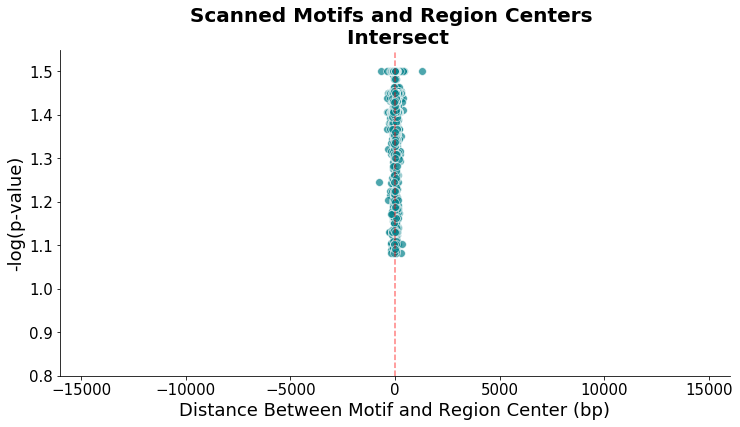

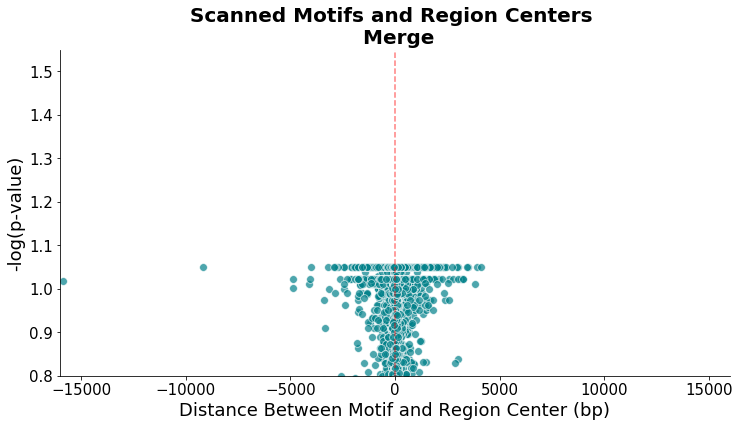

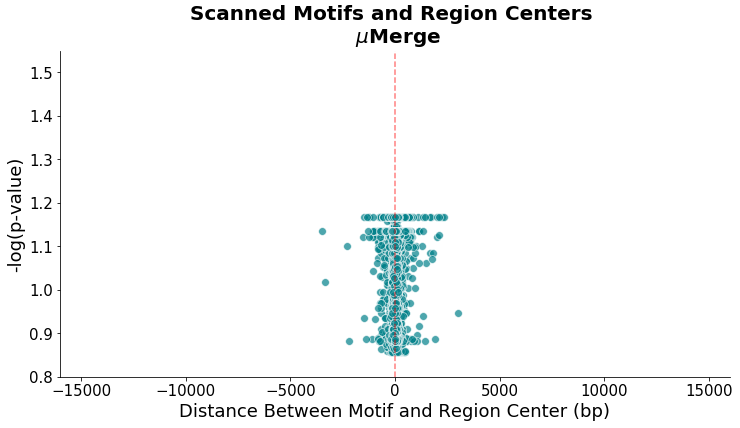

In [46]:
merge_samples_ids = ['Intersect', 'Merge', r'$\mu$Merge']

for dist, sig, label in zip(merge_distances, merge_motif_sig, merge_samples_ids):
  
    fig, ax0 = plt.subplots(figsize=(12, 6))

    ax08 = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color='#02818a', alpha=0.7)
    ax08.axvline(0, ls='--', color='red', linewidth=1.5, alpha=.5)
    ax08.set_title('Scanned Motifs and Region Centers \n {}'.format(label),
                 fontsize=20, fontweight='bold')
    ax08.set_xlabel('Distance Between Motif and Region Center (bp)',fontsize=18)
    ax08.set_ylabel('-log(p-value)',fontsize=18)
    ax08.spines['right'].set_visible(False)
    ax08.spines['top'].set_visible(False)
    plt.legend(prop={'size': 12}, title = '')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax08.set(xlim=(-16000, 16000))
    ax08.set(ylim=(0.8, 1.55))
    
    #fig.savefig("./figures/pdf/JUN_merged_RegionCenter_Motif_distances_{}.pdf".format(label), bbox_inches='tight')
    #fig.savefig("./figures/png/JUN_merged_RegionCenter_Motif_distances_{}.png".format(label), bbox_inches='tight')
    